<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/LSTM%2BContrastive5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Concatenate, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

In [53]:
from google.colab import drive
SEQ_LENGTH = 10
EMBEDDING_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 10
TEST_SIZE = 0.2
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/contrastive_results3/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
def load_and_preprocess_data(data_path, max_users=100, max_files_per_user=30):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]

    for user in user_dirs:
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])[:max_files_per_user]

        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()

    scaler = MinMaxScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler

In [55]:
df, user_ids, scaler = load_and_preprocess_data(DATA_PATH, max_users=100, max_files_per_user=30)

In [56]:
def create_sequences_and_save(df, user_ids, seq_length, test_size=0.2, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in df.groupby('user'):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def process_chunk(data, is_train=True):
            window_size = seq_length + 1
            data_values = data[features].values

            if len(data_values) < window_size:
                print(f"недостаточно данных для пользователя {uid}. пропуск.")
                return [], []

            # создание окон
            X = np.lib.stride_tricks.sliding_window_view(data_values, (window_size, data_values.shape[1]))
            X = X.squeeze(axis=1)
            X = X[:, :-1]
            y = data[targets].values[seq_length:]

            chunk_size = 1000
            for i in range(0, len(X), chunk_size):
                save_chunk(X[i:i+chunk_size], y[i:i+chunk_size], is_train)

            return [], []

        def save_chunk(X, y, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X,
                y=y
            )

        process_chunk(user_df.iloc[:split_idx], is_train=True)
        process_chunk(user_df.iloc[split_idx-seq_length:], is_train=False)

In [57]:
import shutil
shutil.rmtree(SEQ_SAVE_PATH)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

In [58]:
import uuid
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

In [59]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test, users_train, users_test = [], [], [], [], [], []

    for fname in sorted(os.listdir(save_path)):
        if not fname.endswith('.npz'):
            continue

        if 'train' in fname:
            split_type = 'train'
        elif 'test' in fname:
            split_type = 'test'
        else:
            continue

        uid = int(fname.split('_')[1])

        data = np.load(os.path.join(save_path, fname))

        X = data['X']
        y = data['y']

        if split_type == 'train':
            X_train.append(X)
            y_train.append(y)
            users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X)
            y_test.append(y)
            users_test.append(np.full(len(X), uid))

    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [60]:
X_train, X_test, y_train, y_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)
print("X_train shape:", X_train.shape)

X_train shape: (2868992, 10, 7)


In [61]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self, num_users, embedding_dim):
        super().__init__()
        self.embedding = Embedding(num_users, embedding_dim)
        self.dense = Dense(embedding_dim, activation='tanh')

    def call(self, inputs):
        user_id = inputs
        user_emb = self.embedding(user_id)
        return self.dense(user_emb)

    def train_step(self, data):
        users, _ = data
        with tf.GradientTape() as tape:
            embeddings = self(users)

            anchor = embeddings[:-1]
            positive = embeddings[1:]

            distances = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
            loss = self.compiled_loss(tf.zeros_like(distances), distances)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}

In [62]:
contrastive_model = ContrastiveModel(num_users=len(user_ids), embedding_dim=EMBEDDING_DIM)
contrastive_model.compile(optimizer=Adam(0.001), loss=tf.keras.losses.MeanSquaredError())
contrastive_model.fit(users_train, np.zeros(len(users_train)), epochs=5, batch_size=BATCH_SIZE)
user_embeddings = contrastive_model.predict(np.unique(users_train))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


44828/44828 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 2.3403e-07
Epoch 2/5
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 5.9280e-10
Epoch 3/5
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 1.1896e-12
Epoch 4/5
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 1.1432e-13
Epoch 5/5
44828/44828 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 8.1666e-14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [63]:
print("X_train shape:", X_train.shape)

X_train shape: (2868992, 10, 7)


In [64]:
def combine_features(X, users, embeddings):

    if X.ndim == 4 and X.shape[1] == 1:
        X = X.squeeze(axis=1)
    elif X.ndim != 3:
        raise ValueError(f"некорректная размерность X: {X.shape}. ожидается (N, seq_len, features).")

    user_embs = embeddings[users]
    embeddings_expanded = np.repeat(user_embs[:, np.newaxis, :], SEQ_LENGTH, axis=1)

    combined = np.concatenate([X, embeddings_expanded], axis=-1)
    print(f"X shape: {X.shape}, embeddings_expanded shape: {embeddings_expanded.shape}, combined shape: {combined.shape}")
    return combined

X_train_combined = combine_features(X_train, users_train, user_embeddings)
X_test_combined = combine_features(X_test, users_test, user_embeddings)

X shape: (2868992, 10, 7), embeddings_expanded shape: (2868992, 10, 16), combined shape: (2868992, 10, 23)
X shape: (717540, 10, 7), embeddings_expanded shape: (717540, 10, 16), combined shape: (717540, 10, 23)


In [65]:
def build_lstm_model(seq_length, embedding_dim, num_features, num_users):
    seq_input = Input(shape=(seq_length, num_features))
    user_input = Input(shape=(1,), dtype=tf.int32)

    user_emb = Embedding(num_users, embedding_dim)(user_input)
    user_emb = Reshape((embedding_dim,))(user_emb)

    lstm_out = LSTM(LSTM_UNITS, return_sequences=False)(seq_input)
    combined = Concatenate()([lstm_out, user_emb])

    dense_out = Dense(64, activation='relu')(combined)
    dense_out = Dense(32, activation='relu')(dense_out)
    final_output = Dense(2, activation='linear')(dense_out)

    model = Model(inputs=[seq_input, user_input], outputs=final_output)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [66]:
def sequence_generator(file_list, batch_size, seq_length, embedding_matrix):
    def generator():
        for file in file_list:
            data = np.load(file)
            X = data['X_train']
            y = data['y_train']
            user_id = data['user_id']
            emb = embedding_matrix[user_id]
            emb_expanded = np.repeat(emb[np.newaxis, :], seq_length, axis=0)

            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                u_batch = np.array([user_id] * len(X_batch))
                emb_batch = np.repeat(emb[np.newaxis, :], len(X_batch) * seq_length, axis=0).reshape(len(X_batch), seq_length, -1)
                yield (np.concatenate([X_batch, emb_batch], axis=-1), u_batch), y_batch
    return generator

In [67]:
def create_dataset_from_generator(npz_folder, batch_size, seq_length, embedding_matrix, split='train'):
    file_list = sorted([os.path.join(npz_folder, f) for f in os.listdir(npz_folder) if f.endswith('.npz')])

    def dataset_gen():
        for file in file_list:
            data = np.load(file)
            X = data[f'X_{split}']
            y = data[f'y_{split}']
            user_id = data['user_id']
            emb = embedding_matrix[user_id]
            emb_expanded = np.repeat(emb[np.newaxis, :], seq_length, axis=0)

            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                u_batch = np.array([user_id] * len(X_batch))
                emb_batch = np.repeat(emb[np.newaxis, :], len(X_batch) * seq_length, axis=0).reshape(len(X_batch), seq_length, -1)
                yield (np.concatenate([X_batch, emb_batch], axis=-1), u_batch), y_batch

    output_signature = (
        (
            tf.TensorSpec(shape=(None, seq_length, X.shape[2] + embedding_matrix.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(
        dataset_gen,
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

In [68]:
model = build_lstm_model(SEQ_LENGTH, EMBEDDING_DIM, X_train_combined.shape[2], len(user_ids))

checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 'best_model.h5'),
                             save_best_only=True, monitor='val_loss')

history = model.fit(
    [X_train_combined, users_train], y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint]
)

Epoch 1/10
35861/35863 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0061

35863/35863 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - loss: 0.0016 - mae: 0.0061 - val_loss: 0.0036 - val_mae: 0.0062
Epoch 2/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - loss: 3.8955e-06 - mae: 0.0013 - val_loss: 0.0043 - val_mae: 0.0069
Epoch 3/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - loss: 2.4820e-06 - mae: 9.9209e-04 - val_loss: 0.0054 - val_mae: 0.0067
Epoch 4/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 197s 6ms/step - loss: 2.0580e-06 - mae: 8.3603e-04 - val_loss: 0.0059 - val_mae: 0.0068
Epoch 5/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - loss: 1.7156e-06 - mae: 7.7407e-04 - val_loss: 0.0097 - val_mae: 0.0085
Epoch 6/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - loss: 1.7211e-06 - mae: 6.9065e-04 - val_loss: 0.0087 - val_mae: 0.0078
Epoch 7/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - loss: 1.3450e-06 - mae: 6.2355e-04 - val_loss: 0.0093 - val_mae: 0.0082
Epoch 8/10
35863/35863 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - loss: 1.4274e-06 - mae: 6.0649e-04 - va

22424/22424 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step
ADE: 0.0071, FDE: 54.5374, Accuracy@1: 0.4120


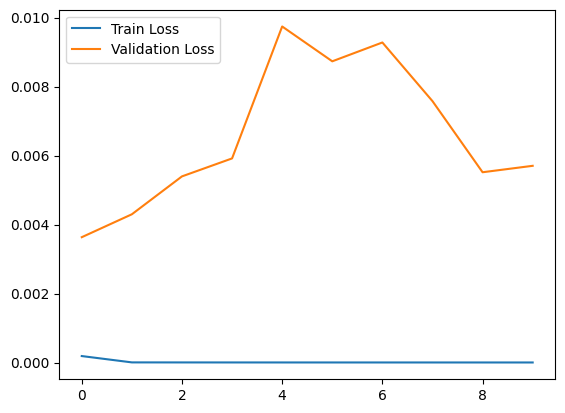

In [69]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.linalg.norm(preds[:, -1] - targets[:, -1], axis=-1).mean()
    distances = np.linalg.norm(preds[:, None] - targets[:, :, None], axis=-1)
    acc1 = np.mean(np.argmin(distances, axis=-1) == 0)
    return ade, fde, acc1

model.load_weights(os.path.join(SAVE_PATH, 'best_model.h5'))
y_pred = model.predict([X_test_combined, users_test])

ade, fde, acc1 = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, Accuracy@1: {acc1:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()